In [16]:
import os
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
from multiprocessing import Pool, cpu_count
from collections import Counter
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem.Scaffolds import MurckoScaffold

def smiles_to_ecfp(smiles_list, radius=2, n_bits=1024):
    """将SMILES转换为ECFP指纹"""
    fingerprints = []
    valid_smiles = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
            fingerprints.append(fp)
            valid_smiles.append(smi)
        else:
            print(f"无法解析SMILES: {smi}")
    return fingerprints, valid_smiles

def tanimoto_similarity(args):
    """计算Tanimoto相似性"""
    i, j, fps = args
    return i, j, DataStructs.TanimotoSimilarity(fps[i], fps[j])

def tanimoto_distance_matrix(fingerprints):
    """计算Tanimoto相似性矩阵并转换为距离矩阵"""
    num = len(fingerprints)
    if num == 1:
        return np.array([[0]])
    
    distance_matrix = np.ones((num, num))  # 先填充为1
    pool = Pool(min(4, cpu_count()))  # 限制最大进程数
    results = pool.map(tanimoto_similarity, [(i, j, fingerprints) for i in range(num) for j in range(i + 1, num)])
    pool.close()
    pool.join()
    
    for i, j, sim in results:
        distance_matrix[i, j] = distance_matrix[j, i] = 1 - sim  # 计算距离
    return distance_matrix

def hierarchical_clustering(distance_matrix, labels, output_csv, t=0.7):
    """使用层次聚类并输出CSV文件"""
    condensed_dist_matrix = pdist(distance_matrix, metric="euclidean")
    linkage_matrix = sch.linkage(condensed_dist_matrix, method='average')
    clusters = sch.fcluster(linkage_matrix, t=t, criterion='distance')
    df = pd.DataFrame({"SMILES": labels, "Cluster": clusters})
    df.to_csv(output_csv, index=False)
    print(f"聚类结果已保存到 {output_csv}")
    
    # 统计聚类信息
    print("聚类统计信息：")
    print(df["Cluster"].value_counts().sort_index())
    
    # 确保输出目录存在
    output_dir = os.path.dirname(output_csv)
    os.makedirs(output_dir, exist_ok=True)
    
    # 绘制树状图
    plt.figure(figsize=(10, 7))
    if len(labels) > 500:
        sch.dendrogram(linkage_matrix, no_labels=True)
    else:
        sch.dendrogram(linkage_matrix, labels=labels, leaf_rotation=90)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Compound Index')
    plt.ylabel('Distance')
    
    # 保存图像
    for ext in ['pdf', 'svg', 'png', 'tiff']:
        plt.savefig(os.path.join(output_dir, f"dendrogram.{ext}"), format=ext, dpi=300, bbox_inches='tight')
    print("树状图已保存")
    plt.show()

def extract_scaffold(smiles):
    """提取Murcko Scaffold"""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    return None

def analyze_cluster_scaffolds(df):
    """分析每个簇的scaffold"""
    cluster_scaffolds = {}
    for cluster, group in df.groupby("Cluster"):
        scaffolds = [extract_scaffold(smiles) for smiles in group["SMILES"]]
        scaffolds = [s for s in scaffolds if s]
        if scaffolds:
            most_common_scaffold = Counter(scaffolds).most_common(1)[0][0]
        else:
            most_common_scaffold = "No scaffold"
        cluster_scaffolds[cluster] = most_common_scaffold
        print(f"Cluster {cluster}: 最常见的scaffold = {most_common_scaffold}")
    return cluster_scaffolds

In [17]:
# 读取CSV文件
input_csv = "/export/home/zhaoyh/HXY/choose.csv"
df = pd.read_csv(input_csv)
smiles_list = df["SMILES"].tolist()

In [18]:
# 计算指纹
fingerprints, valid_smiles = smiles_to_ecfp(smiles_list)

In [19]:
# 计算Tanimoto距离矩阵
distance_matrix = tanimoto_distance_matrix(fingerprints)

聚类结果已保存到 /export/home/zhaoyh/HXY/clusters0305.csv
聚类统计信息：
1    7
2    1
3    1
4    1
Name: Cluster, dtype: int64
树状图已保存


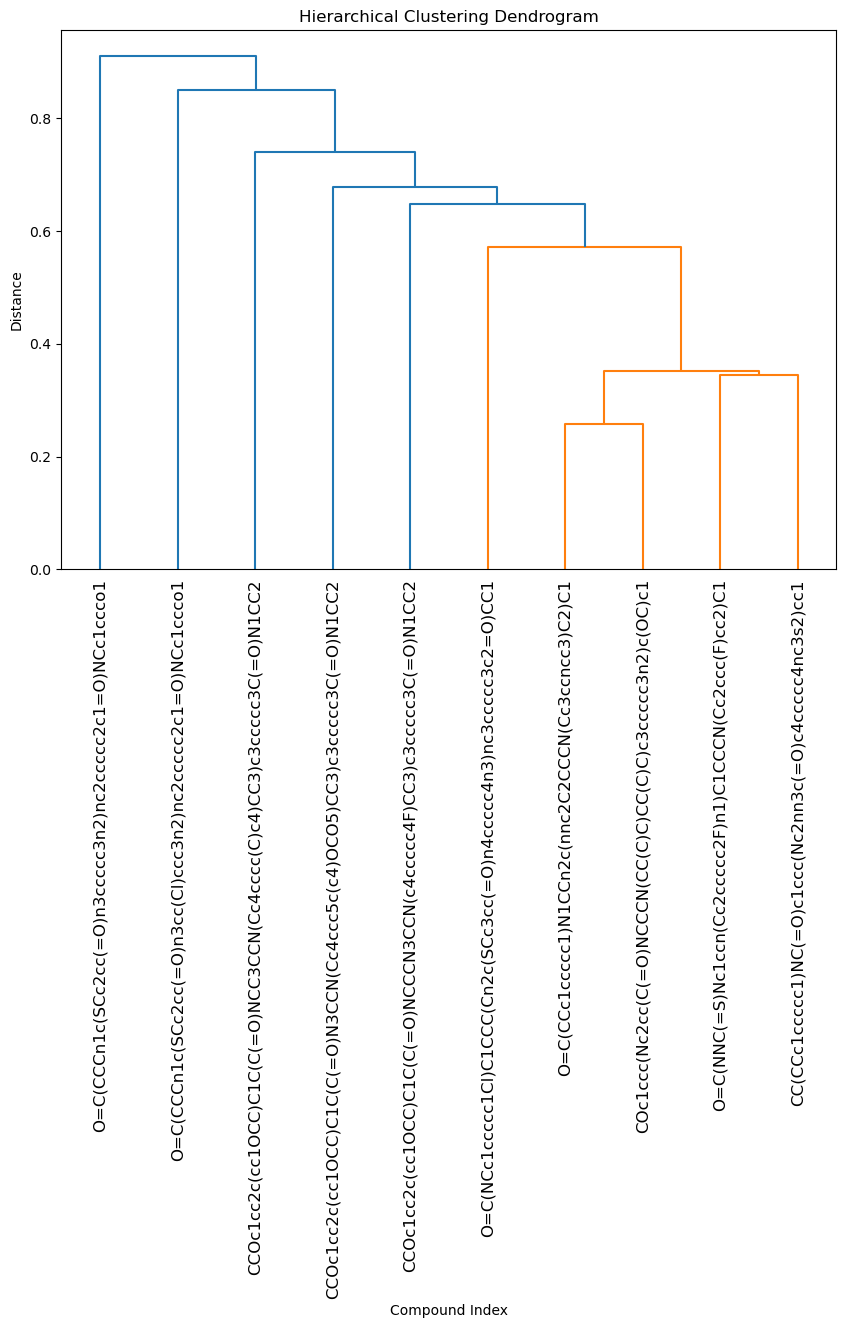

In [20]:
# 层次聚类
output_csv = "/export/home/zhaoyh/HXY/clusters0305.csv"
hierarchical_clustering(distance_matrix, valid_smiles, output_csv, t=0.7)

In [ ]:
# 读取聚类结果
if os.path.exists(output_csv):
    df_clusters = pd.read_csv(output_csv)
    cluster_scaffolds = analyze_cluster_scaffolds(df_clusters)
# 保存scaffold分析结果
    scaffold_df = pd.DataFrame(list(cluster_scaffolds.items()), columns=["Cluster", "Scaffold"])
    scaffold_df.to_csv("/export/home/zhaoyh/HXY/cluster_scaffolds.csv", index=False)
    print("Scaffold分析结果已保存")

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem.Scaffolds import MurckoScaffold
import numpy as np
import scipy.cluster.hierarchy as sch
from multiprocessing import Pool, cpu_count
from collections import Counter
import matplotlib.pyplot as plt
import os

def smiles_to_ecfp(smiles_list, radius=2, n_bits=1024):
    """将SMILES转换为ECFP指纹"""
    fingerprints = []
    valid_smiles = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
            fingerprints.append(fp)
            valid_smiles.append(smi)
        else:
            print(f"无法解析SMILES: {smi}")
    return fingerprints, valid_smiles

def tanimoto_similarity(args):
    """计算Tanimoto相似性"""
    i, j, fps = args
    return i, j, DataStructs.TanimotoSimilarity(fps[i], fps[j])

def tanimoto_distance_matrix(fingerprints):
    """计算Tanimoto相似性矩阵并转换为距离矩阵"""
    num = len(fingerprints)
    distance_matrix = np.zeros((num, num))
    pool = Pool(min(4, cpu_count()))  # 限制最大进程数为4
    results = pool.map(tanimoto_similarity, [(i, j, fingerprints) for i in range(num) for j in range(i + 1, num)])
    pool.close()
    pool.join()
    
    for i, j, sim in results:
        distance_matrix[i, j] = distance_matrix[j, i] = 1 - sim  # 转换为距离
    return distance_matrix

def export_dendrogram_data(linkage_matrix, labels, output_csv):
    """导出树状图数据到CSV文件"""
    linkage_df = pd.DataFrame(linkage_matrix, columns=["Cluster1", "Cluster2", "Distance", "Size"])
    linkage_df["Label1"] = labels[:len(linkage_matrix)]
    linkage_df["Label2"] = labels[:len(linkage_matrix)]
    linkage_df.to_csv(output_csv, index=False)
    print(f"树状图数据已保存到 {output_csv}")

def hierarchical_clustering(distance_matrix, labels, output_csv, t=0.8):
    """使用层次聚类并输出CSV文件"""
    linkage_matrix = sch.linkage(distance_matrix, method='average')
    clusters = sch.fcluster(linkage_matrix, t=t, criterion='distance')  # 设定聚类阈值
    df = pd.DataFrame({"SMILES": labels, "Cluster": clusters})
    df.to_csv(output_csv, index=False)
    print(f"聚类结果已保存到 {output_csv}")
    
    # 输出聚类统计信息
    cluster_sizes = df["Cluster"].value_counts().sort_index()
    print("聚类统计信息：")
    print(cluster_sizes)
    
    # 可视化树状图
    plt.figure(figsize=(10, 7))
    if len(labels) > 500:  # 数据量较大时隐藏标签
        sch.dendrogram(linkage_matrix, no_labels=True)
    else:
        sch.dendrogram(linkage_matrix, labels=labels, leaf_rotation=90)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Compound Index')
    plt.ylabel('Distance')
    
    # 确保输出目录存在
    output_dir = os.path.dirname(output_csv)
    os.makedirs(output_dir, exist_ok=True)
    
    # 保存为多种格式
    for ext in ['pdf', 'svg', 'png', 'tiff']:
        plt.savefig(os.path.join(output_dir, f"dendrogram.{ext}"), format=ext, dpi=300, bbox_inches='tight')
    print("树状图已保存为 PDF、SVG、PNG 和 TIFF 格式")
    
    # 导出树状图数据
    export_dendrogram_data(linkage_matrix, labels, os.path.join(output_dir, "dendrogram_data.csv"))
    
    plt.show()  # 显示树状图

def extract_scaffold(smiles):
    """从SMILES中提取Murcko Scaffold"""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    return None

def analyze_cluster_scaffolds(df):
    """分析每个簇的scaffold"""
    cluster_scaffolds = {}
    for cluster, group in df.groupby("Cluster"):
        scaffolds = [extract_scaffold(smiles) for smiles in group["SMILES"]]
        scaffolds = [s for s in scaffolds if s]  # 过滤掉无效的scaffold
        if scaffolds:
            most_common_scaffold = Counter(scaffolds).most_common(1)[0][0]
        else:
            most_common_scaffold = "No scaffold"
        cluster_scaffolds[cluster] = most_common_scaffold
        print(f"Cluster {cluster}: 最常见的scaffold = {most_common_scaffold}")
    return cluster_scaffolds

In [2]:
# 主程序
if __name__ == "__main__":
    # 1. 从CSV文件读取SMILES
    input_csv = "/export/home/zhaoyh/HXY/choose.csv"
    df = pd.read_csv(input_csv)
    smiles_list = df["SMILES"].tolist()

In [3]:
    # 2. 计算ECFP指纹
    fingerprints, valid_smiles = smiles_to_ecfp(smiles_list)

In [4]:
    # 3. 计算Tanimoto距离矩阵
    distance_matrix = tanimoto_distance_matrix(fingerprints)

/tmp/ipykernel_37343/1164461877.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_matrix, method='average')


聚类结果已保存到 /export/home/zhaoyh/HXY/clusters03014.csv
聚类统计信息：
1    3
2    3
3    1
4    1
5    1
6    1
Name: Cluster, dtype: int64
树状图已保存为 PDF、SVG、PNG 和 TIFF 格式
树状图数据已保存到 /export/home/zhaoyh/HXY/dendrogram_data.csv


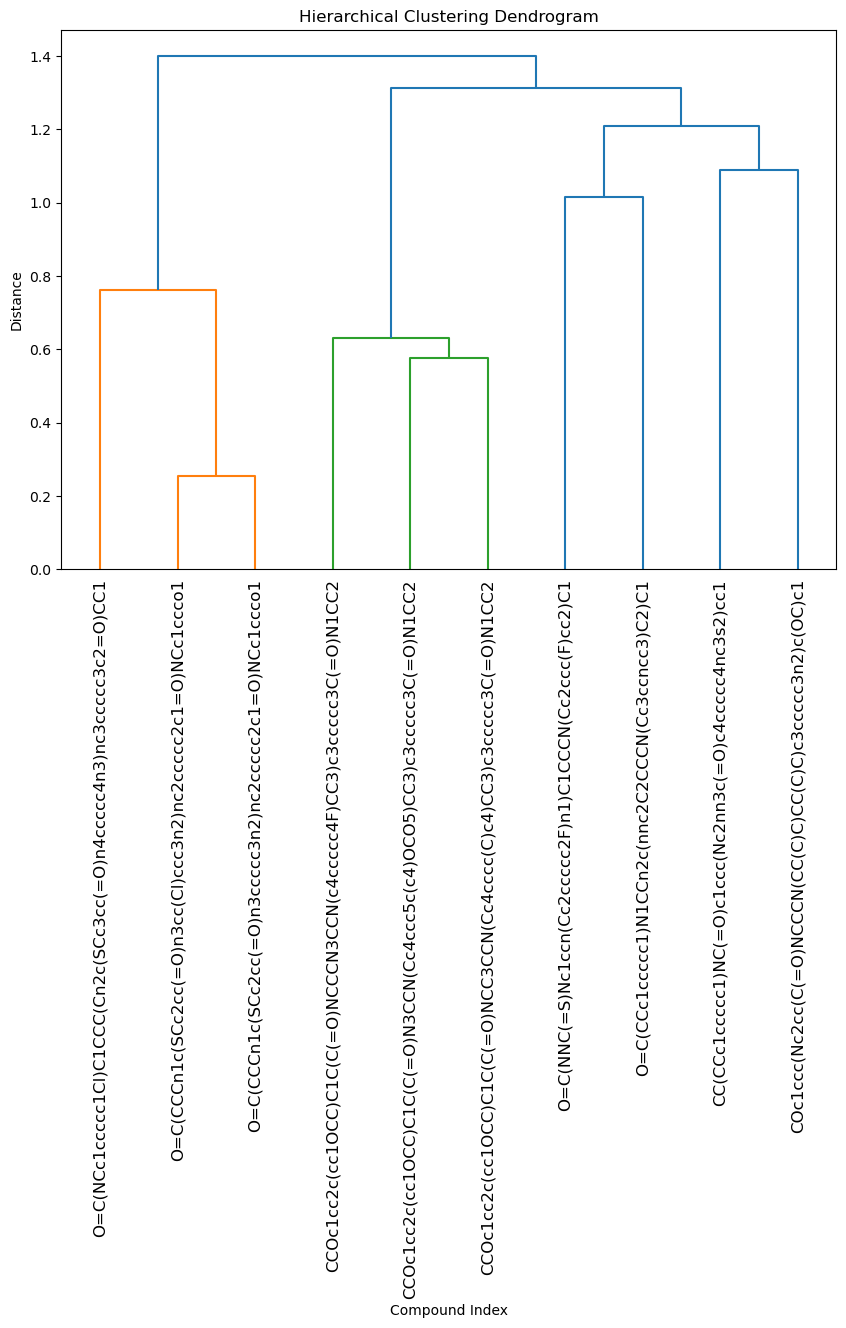

In [6]:
    # 4. 进行层次聚类并保存结果
    output_csv = "/export/home/zhaoyh/HXY/clusters03014.csv"
    hierarchical_clustering(distance_matrix, valid_smiles, output_csv, t=0.8)

In [30]:
    # 5. 分析每个簇的scaffold
    df_clusters = pd.read_csv(output_csv)
    cluster_scaffolds = analyze_cluster_scaffolds(df_clusters)

Cluster 1: 最常见的scaffold = O=C(CCCn1c(SCc2cc(=O)n3ccccc3n2)nc2ccccc2c1=O)NCc1ccco1
Cluster 2: 最常见的scaffold = O=C(C1c2ccccc2C(=O)N2CCc3ccccc3C12)N1CCN(Cc2ccc3c(c2)OCO3)CC1
Cluster 3: 最常见的scaffold = O=C(NNC(=S)Nc1ccn(Cc2ccccc2)n1)C1CCCN(Cc2ccccc2)C1
Cluster 4: 最常见的scaffold = O=C(CCc1ccccc1)N1CCn2c(nnc2C2CCCN(Cc3ccncc3)C2)C1
Cluster 5: 最常见的scaffold = O=C(NCCCc1ccccc1)c1ccc(Nc2nn3c(=O)c4ccccc4nc3s2)cc1
Cluster 6: 最常见的scaffold = c1ccc(Nc2ccc3ccccc3n2)cc1


In [31]:
    # 6. 保存scaffold分析结果
    scaffold_df = pd.DataFrame(list(cluster_scaffolds.items()), columns=["Cluster", "Scaffold"])
    scaffold_df.to_csv("/export/home/zhaoyh/HXY/cluster_scaffolds.csv", index=False)
    print("Scaffold分析结果已保存到 cluster_scaffolds.csv")

Scaffold分析结果已保存到 cluster_scaffolds.csv
